In [1]:
# imports 
import os
import numpy as np
import pandas as pd
from skimage import io
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy import interpolate

import time

# Provide directories

In [2]:
# Expected that the staining_dir has input files for DAPI, GFP, mask, stain1, and stain2
staining_dir = '/media/user/Extreme SSD/Staining/norwegian/publication_inputs/'
npy_dir = '/media/user/Extreme SSD/Staining/norwegian/publication_npy/'
out_dir = '/media/user/Extreme SSD/Staining/norwegian/publication_out/'

In [3]:
# Specify the models to use
models = ['/home/user/Documents/STIFMap_publication_code/STIFMaps/trained_models/iteration_1010.pt',
          '/home/user/Documents/STIFMap_publication_code/STIFMaps/trained_models/iteration_1011.pt',
          '/home/user/Documents/STIFMap_publication_code/STIFMaps/trained_models/iteration_1012.pt',
          '/home/user/Documents/STIFMap_publication_code/STIFMaps/trained_models/iteration_1013.pt',
          '/home/user/Documents/STIFMap_publication_code/STIFMaps/trained_models/iteration_1014.pt'
        ]

# Define functions used below

In [4]:
# Normalize an image from 0-1
def norm_pic(im):
    # Find the thresholds
    hmin = np.quantile(im.flatten(), .01)
    hmax = np.quantile(im.flatten(), .99)

    # Create the new thresholded image
    im2 = (im - hmin) / (hmax-hmin)
    im2 = np.clip(im2, 0, 1)
    
    return im2

# Given the step size between squares and the scale factor between the input
#      image and the training data, find the actual step size to use in the input image
#      Note that the output step size must be an even number 
def get_step(step, scale_factor):
    step = step / scale_factor

    if round(step) % 2 == 0:
        return round(step)
    elif round(step) == int(step):
        return round(step)+1
    else:
        return int(step)

# Specify Parameters

In [5]:
# Scale factor to convert from HER2 slide scans to SP5
scale_factor = 1.8025

# How many squares to evaluate at once with the network
batch_size = 100

# The pixel threshold to use when comparing STIFMaps/DAPI/GFP vs stain intensity
quantile = .99

# used to downsample images if the full images use too much memory
scale_percent = 100

# The step size to use from one square to the next
step = 40



# Get the actual step size given the scale_factor
step = get_step(step, scale_factor)
# and the half step size
half_step = int(step/2)

print(step)
print(half_step)

# Get the actual side length of one square
square_side = get_step(224, scale_factor)
# and the half side length
half_side = int(square_side/2)

print(square_side)
print(half_side)

22
11
124
62


# Organize the input files

In [6]:
files = os.listdir(staining_dir)

files.sort()

dapis = files[0::5]
gfps = files[1::5]
masks = files[3::5]
stain1s = files[4::5]
stain2s = files[2::5]

names = [gfp.split('_')[0] for gfp in gfps]

sample_list = pd.DataFrame({
    'name':names,
    'dapi_file':dapis,
    'gfp_file':gfps,
    'mask_file':masks,
    'stain1_file':stain1s,
    'stain2_file':stain2s
})

sample_list

,name,dapi_file,gfp_file,mask_file,stain1_file,stain2_file
0,0040,0040_DAPI.TIF,0040_GFP.TIF,0040_MASK.TIF,0040_ZEB1.TIF,0040_HER2.TIF
1,0048,0048_DAPI.TIF,0048_GFP.TIF,0048_MASK.TIF,0048_ZEB1.TIF,0048_HER2.TIF
2,0053-2,0053-2_DAPI.TIF,0053-2_GFP.TIF,0053-2_MASK.TIF,0053-2_ZEB1.TIF,0053-2_HER2.TIF
3,0053,0053_DAPI.TIF,0053_GFP.TIF,0053_MASK.TIF,0053_ZEB1.TIF,0053_HER2.TIF
4,0069,0069_DAPI.TIF,0069_GFP.TIF,0069_MASK.TIF,0069_ZEB1.TIF,0069_HER2.TIF
5,6450,6450_DAPI.TIF,6450_GFP.TIF,6450_MASK.TIF,6450_ZEB1.TIF,6450_HER2.TIF
6,6748-2,6748-2_DAPI.TIF,6748-2_GFP.TIF,6748-2_MASK.TIF,6748-2_ZEB1.TIF,6748-2_HER2.TIF
7,6748,6748_DAPI.TIF,6748_GFP.TIF,6748_MASK.TIF,6748_ZEB1.TIF,6748_HER2.TIF
8,6930,6930_DAPI.TIF,6930_GFP.TIF,6930_MASK.TIF,6930_ZEB1.TIF,6930_HER2.TIF
9,7126,7126_DAPI.TIF,7126_GFP.TIF,7126_MASK.TIF,7126_ZEB1.TIF,7126_HER2.TIF


# Load the Network

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        #_log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Get STIFMap

In [9]:
valid_transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x[0:2]) # Remove the blank channel
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

0040
(3, 14742, 3262)
143
665
Time taken to predict squares is 110.25970911979675
Time taken to predict squares is 226.7503900527954


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



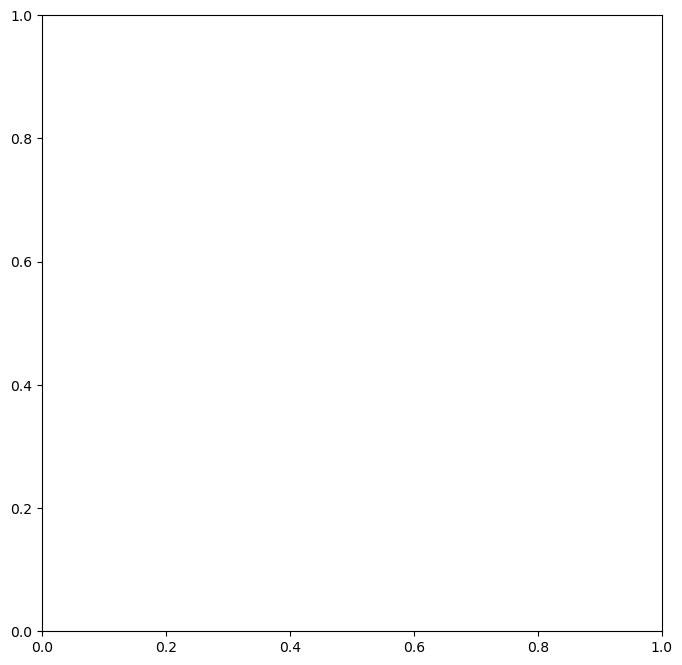

In [10]:
then = time.time()

fig, ax = plt.subplots(figsize=(8,8))
    
for im_num in range(1):#len(gfps)):

    name = names[im_num]

    print(name)

    ############################################ Import the images
    dapi = io.imread(staining_dir + dapis[im_num])
    gfp = io.imread(staining_dir + gfps[im_num])
    mask = io.imread(staining_dir + masks[im_num])

    # Normalize the images
    dapi = norm_pic(dapi)
    gfp = norm_pic(gfp)
    # Convert the datatype
    dapi = dapi.astype(np.float32)
    gfp = gfp.astype(np.float32)

    
    '''    
    ######################### Save the dapi norm pic
    #io.imsave(out_dir + name + '_DAPI_norm.TIF', dapi)
    ######################### Save the gfp norm pic
    #io.imsave(out_dir + name + '_GFP_norm.TIF', gfp)
    '''
    
    blank = np.zeros(shape = gfp.shape, dtype = np.float32)

    im = np.stack((gfp,dapi,blank), axis=0)

    print(im.shape)
    
    del dapi
    del gfp
    del blank

    ######################### Split into squares

    x_range = int((im.shape[2] - square_side) / (step)) + 1
    y_range = int((im.shape[1] - square_side) / (step)) + 1

    print(x_range)
    print(y_range)
    #print(xy_range)

    x = np.array(list(range(x_range)) * y_range)
    y = [[i]*x_range for i in list(range(y_range))]
    y = np.array(y)
    y = y.flatten()

    then2 = time.time()

    for model in models:
        model_name = model[-7:-3]
        
        squares = []
        outputs = []

        #network = densenet121()
        network = AlexNet()

        network.load_state_dict(torch.load(model))
        network.eval()
        #network.train()

        masked_value_tracker = []
        #print('test1')
        for i in range(len(x)):
            #print(i)
            #gfp_sub = gfp[side_length*y[i]:side_length*(y[i]+1), side_length*x[i]:side_length*(x[i]+1)]
            #gfp_sub = gfp[step*y[i]:step*(y[i]+2), step*x[i]:step*(x[i]+2)]
            masked_value = mask[step*y[i] + half_side, step*x[i] + half_side]
            masked_value_tracker.append(masked_value)
            
            if masked_value != 0:
                im_sub = im[:,step*y[i]:step*y[i] + square_side, step*x[i]:step*x[i] + square_side].copy()
                im_sub = torch.from_numpy(im_sub)#.float()
                
                #print(im_sub.shape)
                im_sub = valid_transform(im_sub)
                #print(im_sub.shape)
                #gfp_sub = np.reshape(gfp_sub, (side_length*side_length))
                #print(gfp_sub.shape)
                #io.imsave(out_dir + str(i)+'_im.tif', im_sub)

                squares.append(im_sub)
                
            

            if (i % batch_size == 0) & (i != 0) & (len(squares) != 0):

                outputs_sub = network(torch.stack(squares))
                outputs_sub = torch.reshape(outputs_sub, (-1,))
                outputs += list(outputs_sub.detach().cpu().numpy().flatten())

                squares = [] 

        #print('test2')
        # Add the last one on, but only if theres something there
        if len(squares) != 0:
        
            outputs_sub = network(torch.stack(squares))
            outputs_sub = torch.reshape(outputs_sub, (-1,))
            outputs += list(outputs_sub.detach().cpu().numpy().flatten())

            squares = [] 

        del network 
        
        now2 = time.time()
        print('Time taken to predict squares is ' + str(now2-then2))


        z = outputs
        z = np.array(z)
        
        z_out = []
        j = 0
        for i in range(len(masked_value_tracker)):
            if masked_value_tracker[i] == 0:
                z_out.append(0)
            else:
                z_out.append(z[j])
                j += 1

        z_out = np.array(z_out)
        z_out = z_out.reshape((y_range,x_range))

        np.save(npy_dir + name + '_model_' + model_name + '_STIFMAP.npy', z_out)
    

   
    del im


now = time.time()
print('Total time taken is ' + str(now-then))

# Collagen Painting

In [ ]:
samples = []

# Lists tracking summary statistics
z_stain1_pearson = []
z_stain1_spearman = []
z_stain2_pearson = []
z_stain2_spearman = []

gfp_stain1_pearson = []
gfp_stain1_spearman = []
gfp_stain2_pearson = []
gfp_stain2_spearman = []

dapi_stain1_pearson = []
dapi_stain1_spearman = []
dapi_stain2_pearson = []
dapi_stain2_spearman = []


# Lists tracking full intervals
dapi_samples_full_intervals = []
dapi_stain1_tracker = []
dapi_stain2_tracker = []
dapi_interval_tracker = []

gfp_samples_full_intervals = []
gfp_stain1_tracker = []
gfp_stain2_tracker = []
gfp_interval_tracker = []

z_samples_full_intervals = []
z_stain1_tracker = []
z_stain2_tracker = []
#z_stain1_tracker_max = []
#z_stain2_tracker_max = []
#z_stain1_tracker_sum = []
#z_stain2_tracker_sum = []
z_interval_tracker = []

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

then = time.time()

for index in range(len(dapis)):
    #for index, row in sample_list.iterrows():
    
    name = names[index]
    print(name)



    #############################################################################
    ########################################## Load the STIFFMap
    #############################################################################
    # Load all of the models
    z1 = np.load(npy_dir + name + '_model_1010_STIFFMAP.npy')
    z2 = np.load(npy_dir + name + '_model_1011_STIFFMAP.npy')
    z3 = np.load(npy_dir + name + '_model_1012_STIFFMAP.npy')
    z4 = np.load(npy_dir + name + '_model_1013_STIFFMAP.npy')
    z5 = np.load(npy_dir + name + '_model_1014_STIFFMAP.npy')
    z = np.mean(np.stack([z1,z2,z3,z4,z5]), axis=0)

    ##### Get the min and max regions of the original STIFMap (not resized)
    z_range = z.flatten()
    # Remove masked regions
    z_range = [i for i in z_range if i != 0]
    z_min = min(z_range)
    z_max = max(z_range)

    y_range = z.shape[0]
    x_range = z.shape[1]

    # Read in the images
    gfp = io.imread(staining_dir + gfps[index])
    mask = io.imread(staining_dir + masks[index])
    dapi = io.imread(staining_dir + dapis[index])
    stain1 = io.imread(staining_dir + stain1s[index])
    stain2 = io.imread(staining_dir + stain2s[index])
    

    #############################################################################
    ########################################## Reduce to remove regions not sampled with the STIFMap
    #############################################################################
    gfp = gfp[half_side - half_step : (y_range-1)*step + half_side + half_step,
         half_side - half_step : (x_range-1)*step + half_side + half_step]
    mask = mask[half_side - half_step : (y_range-1)*step + half_side + half_step,
         half_side - half_step : (x_range-1)*step + half_side + half_step]
    dapi = dapi[half_side - half_step : (y_range-1)*step + half_side + half_step,
         half_side - half_step : (x_range-1)*step + half_side + half_step]

    stain1 = stain1[half_side - half_step : (y_range-1)*step + half_side + half_step,
         half_side - half_step : (x_range-1)*step + half_side + half_step]

    stain2 = stain2[half_side - half_step : (y_range-1)*step + half_side + half_step,
         half_side - half_step : (x_range-1)*step + half_side + half_step]
    

    #############################################################################
    ########################################## Interpolate the stiffmap to make it the same dimensions as the GFP image
    #############################################################################
    x = np.arange(half_step, x_range*step+half_step, step)
    y = np.arange(half_step, y_range*step+half_step, step)

    f = interpolate.interp2d(x, y, z, kind='cubic')

    xnew = np.arange(0,mask.shape[1],1) #np.arange(0,y_range*step,1)
    ynew = np.arange(0,mask.shape[0],1) #np.arange(0,x_range*step,1)
    znew = f(xnew, ynew)
    # Clip to remove negative values
    znew = np.clip(znew, 0, 100000)
    
    #############################################################################
    ########################################## Mask out empty regions
    #############################################################################
    ###### Normalize inputs
    stain1 = norm_pic(stain1)
    stain2 = norm_pic(stain2)
    gfp = norm_pic(gfp)
    mask = norm_pic(mask)
    dapi = norm_pic(dapi)

    
    '''
    #############################################################################
    ########################################## Downsample
    ############ (scale_percent can be used to downsample the image if the full image uses too much memory)
    #############################################################################
    # Find the new dimensions    
    width = int(dapi.shape[1] * scale_percent / 100)
    height = int(dapi.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Downsample the images
    dapi = cv2.resize(dapi, dim, interpolation = cv2.INTER_AREA)
    gfp = cv2.resize(gfp, dim, interpolation = cv2.INTER_AREA)
    stain1 = cv2.resize(stain1, dim, interpolation = cv2.INTER_AREA)
    stain2 = cv2.resize(stain2, dim, interpolation = cv2.INTER_AREA)
    znew = cv2.resize(znew, dim, interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
    '''

    
    
    ############################# Collagen paint
    
    # Mask out unused regions
    znew = znew * mask
    gfp = gfp * mask
    #del mask

    # Clip znew to only include the stiffness range in the original STIFMap
    znew_color = np.clip(znew, z_min, z_max)
    #del znew

    # Get the scaled image in RGB                 
    gfp3 = np.stack([gfp,gfp,gfp], axis=2)
    #del gfp
    # How many colors do we want to use
    n_colors=1000
    hues = sns.color_palette("viridis", n_colors+1)

    # For every pixel, get the index of the hue we want to use
    hue_indices = (n_colors * (znew_color - z_min) / (z_max - z_min)).astype(int)
    hues = np.array(hues)

    # Take the hue for each pixel and multiply by the intensity of the GFP image to get the final output
    znew_color = np.take(hues, hue_indices, axis=0)
    del hue_indices

    gfp_colored = gfp3 * znew_color
    del gfp3
    del znew_color


    plt.imsave(out_dir + name + '_STIFMap.png', gfp_colored)
    del gfp_colored


    ######### Save the colorbar
    a = np.array([[z_min,z_max]])
    plt.figure(figsize=(10, 10))
    img = plt.imshow(a, cmap="viridis")
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.1, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    cbar.ax.set_ylabel('log(elasticity) (Pa)', fontsize=18)
    plt.savefig(out_dir + name + "_colorbar.png")
    
    
    
    
    
    
    ########################################### Plotting    
    
    dapi = dapi.flatten()
    gfp = gfp.flatten()
    stain1 = stain1.flatten()
    stain2 = stain2.flatten()
    znew = znew.flatten()
    mask = mask.flatten()
    
    df = np.zeros((len(gfp),6))

    df[:,0] = dapi
    df[:,1] = gfp
    df[:,2] = stain1
    df[:,3] = stain2
    df[:,4] = znew
    df[:,5] = mask

    del dapi
    del gfp
    del stain1
    del stain2
    del znew
    del mask


    df = pd.DataFrame(df)
    df.columns = ['dapi','gfp','stain1','stain2','z','mask']
    
    # Remove regions that are masked out
    df = df.loc[df['mask'] > .2]
     
    
    #print('Correlation between z and gfp is ' +str(pearsonr(df['gfp'], df['z'])[0]))
    
    ######################################### Looking at 99th stain percentiles for each z interval
    
    samples.append(name)
    
    z_min = int(np.min(df['z'])*100)
    z_max = int((np.max(df['z'])*100)+1)

    intervals = np.array(range(z_min,z_max,1))/100

    stain1_tracker = []
    stain2_tracker = []
    intervals_used = []

    for interval in intervals:
        df_sub = df.loc[df['z'] < interval + .01].loc[df['z'] > interval]
        if df_sub.shape[0] != 0:
            stain1_tracker.append(np.quantile(df_sub['stain1'], .99))
            stain2_tracker.append(np.quantile(df_sub['stain2'], .99))
            intervals_used.append(interval)

    z_stain1_pearson.append(pearsonr(intervals_used, stain1_tracker))
    z_stain2_pearson.append(pearsonr(intervals_used, stain2_tracker))
    z_stain1_spearman.append(spearmanr(intervals_used, stain1_tracker))
    z_stain2_spearman.append(spearmanr(intervals_used, stain2_tracker))

    print(7)
    now = time.time()
    print('time taken is ' + str(now-then))
    
    ######################################### Looking at 99th stain percentiles for each gfp interval
    intervals = np.array(range(1,100))/100

    stain1_tracker = []
    stain2_tracker = []
    intervals_used = []

    for interval in intervals:
        df_sub = df.loc[df['gfp'] < interval + .01].loc[df['gfp'] > interval]
        if df_sub.shape[0] != 0:
            stain1_tracker.append(np.quantile(df_sub['stain1'], .99))
            stain2_tracker.append(np.quantile(df_sub['stain2'], .99))
            intervals_used.append(interval)

    gfp_stain1_pearson.append(pearsonr(intervals_used, stain1_tracker))
    gfp_stain2_pearson.append(pearsonr(intervals_used, stain2_tracker))
    gfp_stain1_spearman.append(spearmanr(intervals_used, stain1_tracker))
    gfp_stain2_spearman.append(spearmanr(intervals_used, stain2_tracker))


    now = time.time()
    print('time taken is ' + str(now-then))
    
    ######################################### Looking at 99th stain percentiles for each dapi interval
    intervals = np.array(range(1,100))/100

    stain1_tracker = []
    stain2_tracker = []
    intervals_used = []

    for interval in intervals:
        df_sub = df.loc[df['dapi'] < interval + .01].loc[df['dapi'] > interval]
        if df_sub.shape[0] != 0:
            stain1_tracker.append(np.quantile(df_sub['stain1'], .99))
            stain2_tracker.append(np.quantile(df_sub['stain2'], .99))
            intervals_used.append(interval)

    dapi_stain1_pearson.append(pearsonr(intervals_used, stain1_tracker))
    dapi_stain2_pearson.append(pearsonr(intervals_used, stain2_tracker))
    dapi_stain1_spearman.append(spearmanr(intervals_used, stain1_tracker))
    dapi_stain2_spearman.append(spearmanr(intervals_used, stain2_tracker))
    
    
    
    del df
    
    
    now = time.time()
    print('Time taken is ' + str(now-then))